# Green Coverage and Accessibility Analysis in Valencia

This project analyzes the availability and accessibility of green zones in Valencia using spatial data on census tracts and green areas. The focus is on evaluating green space distribution, accessibility, and its relationship with socioeconomic status.

The data used for this project comes from the following sources:
- **Census and demographic data**: Retrieved from the [Instituto Nacional de Estadística](https://www.ine.es).
- **Green zones and census tracts geospatial data**: Accessed via the [Geo Portal del Ayuntamiento de Valencia](https://valencia.opendatasoft.com/pages/home/) through an API.

## Methodology

The project is divided into several stages:

1. **Exploratory Green Coverage Analysis**:  
   - **Per Capita Availability of Green Space**: This metric is used to assess the adequacy of green spaces relative to the population density in each census tract. Areas with high population density are identified, where additional green spaces may be required.

2. **Accessibility Analysis**:
   - **2SFCA Method**: Accessibility is measured using the 2-Step Floating Catchment Area (2SFCA) method, which factors in:
     - **Distances**: Manhattan distances between census tracts and green zones.
     - **Green Zone Areas**: Larger green spaces have higher scores.
     - **Catchment Area**: A 500-meter isochrone is used to define the accessible area.
	 - **Population**: The population of census tracts is considered to determine how many people benefit from green spaces within the catchment area.

3. **Spatial Autocorrelation**:
   - **Hot Spot and Cold Spot Analysis**: Spatial autocorrelation analysis is applied to identify clusters of census tracts with high or low green coverage.

4. **Geographically Weighted Regression (GWR)**:
   - **Relationship with Socioeconomic Status**: GWR is used to examine the potential correlation between green coverage and socioeconomic indicators such as income and education levels to assess disparities in access to green spaces across different neighborhoods.

In [5]:
# Import libraries

# API requests
import requests

# Data manipulation
import pandas as pd  
import geopandas as gpd  
import pickle 
import numpy as np

# Geometries manipulation
from shapely.geometry import shape, Polygon, MultiPolygon, Point, LineString  

# Visualization
import matplotlib.pyplot as plt  
import seaborn as sns  
import contextily as ctx  

# Spatial analysis
from pysal.lib import weights  
from mgwr.gwr import GWR  
from mgwr.sel_bw import Sel_BW  
from esda.moran import Moran  
import esda  
from splot import esda as esdaplot  

# Statistical analysis
from scipy.stats import norm, shapiro  

# System
from IPython.display import display, HTML
import os  

# Preprocessing
The cleaning process involved filtering the census sections by excluding those from the rural districts of 'Els Pobles' due to their low population density, as outlined in the 'Special Plan for Urban Quality Guidelines' by AUMSA. The central city structure comprises 560 census sections organized into 19 districts. The cleaning and preprocessing steps included merging multiple data sources to create a comprehensive dataset of census tracts, integrating population data along with various socioeconomic indicators such as average income, education levels, and demographics. A new variable for population density was calculated by dividing the population by the area of each tract. Furthermore, district names were standardized for consistency, and any missing district codes were filled and converted to string format to facilitate seamless integration with the green zones dataset.

Green Zones GeoDataFrame extracted successfully
Districts GeoDataFrame extracted succesfully
EPSG:25830


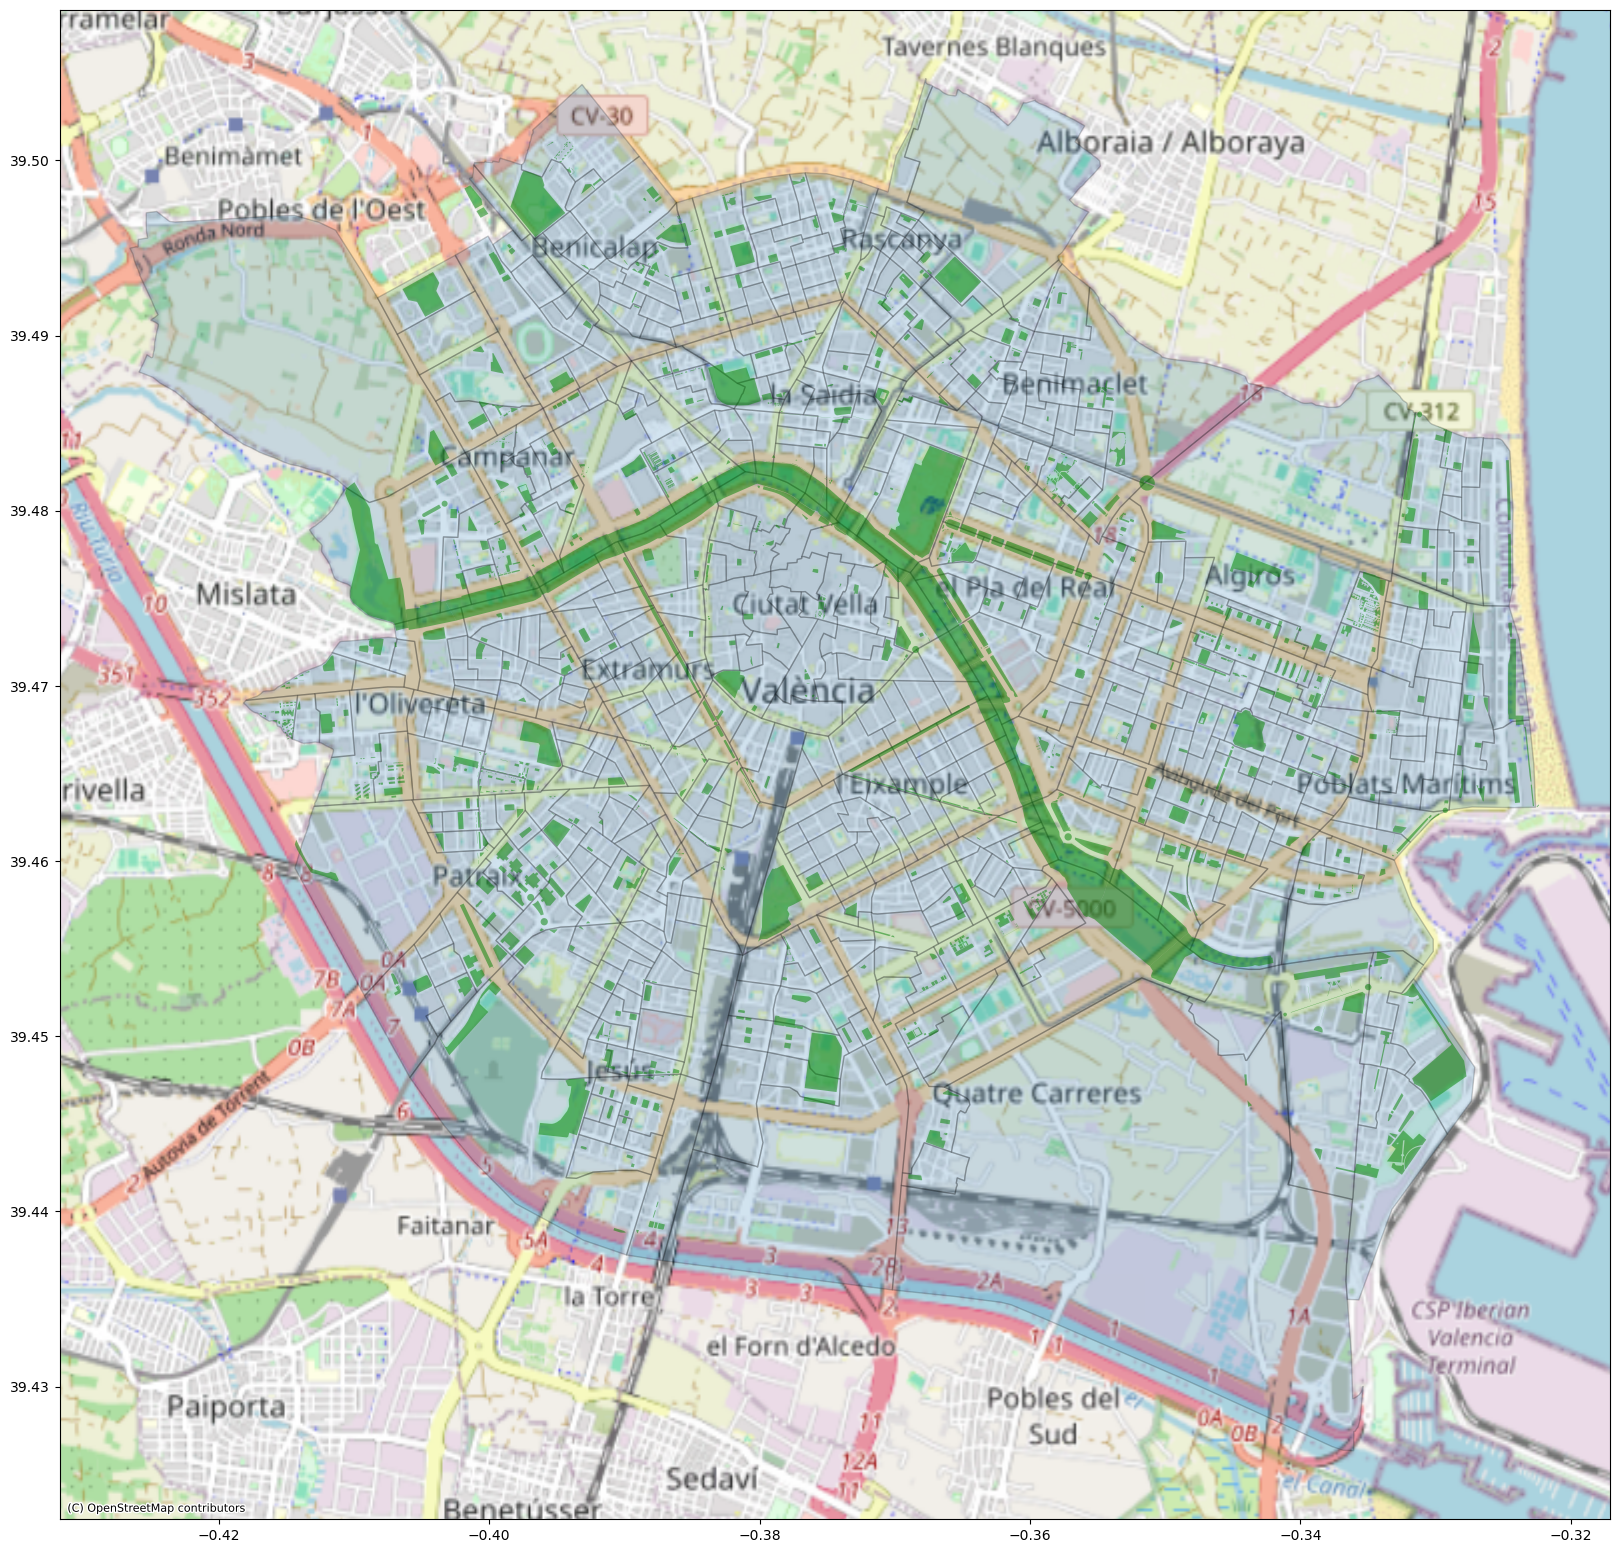

The Green Zones GeoDataFrame contains 434 polygons, each representing a green area categorized into one of three typologies: Parques Urbanos, Jardines Barrio Plaza, Jardines Especial Protección, Unknown

The Census tracts GeoDataFrame contains 560 polygons with 14 features.


coddistrit     CODSECC   population  st_shape_area  population_density  \
count  560.000000  560.000000   560.000000   5.600000e+02          560.000000   
mean     8.594643   22.246429  1333.998214   8.776598e+04            0.031918   
std      4.433363   13.864666   425.465270   2.819453e+05            0.016584   
min      1.000000    1.000000   603.000000   9.575815e+03            0.000152   
25%      5.000000   11.000000  1008.000000   2.909789e+04            0.019784   
50%      9.000000   21.000000  1266.000000   4.183453e+04            0.031612   
75%     12.000000   32.000000  1587.000000   6.794383e+04            0.041904   
max     16.000000   57.000000  3090.000000   5.264195e+06            0.110607   

          age_avg  pct_foreigners  education_avg  pct_unemployed         Vm2  \
count  560.000000      560.000000     560.000000      560.000000  560.000000   
mean    45.170125        0.136744       3.077482        0.166644  418.604899   
std      2.761848        0.064944       0.260910        0.059017  118.348333   
min     33.150000        0.029600       2.550000        0.053400  177.229364   
25%     43.710000        0.089850       2.880000        0.128700  343.679839   
50%     45.470000        0.126950       3.040000        0.161000  390.680811   
75%     46.885000        0.170225       3.290000        0.194850  467.105220   
max     56.360000        0.544900       3.660000        0.407700  929.741397   

         income_avg  
count    560.000000  
mean   35691.523214  
std    11091.875854  
min    16640.000000  
25%    28129.750000  
50%    32831.500000  
75%    39814.750000  
max    88769.000000

In [7]:
%run load_and_process.py

# Green Coverage
This section aims to assess the green area coverage in the city, comparing it across different zones and districts, and calculating the green space available per person in each area. The workflow includes spatial data processing, aggregation of green area coverage, and visualizing the results. In this section we will:
1. Convert park areas to hectares and summarize by type.
3. Calculate total green area and percentage of coverage relative to the municipal area.
4. Link parks to census tracts and aggregate green area and population by zones.
5. Create bar plots to show green coverage per person with WHO benchmarks.

In [27]:
%run coverage.py

1. **Calculating Green Area by Category**
The total area for each green zone is calculated in hectares (ha) by converting the shape area from square meters. The green zones are grouped by their categories (e.g., parks, gardens) to summarize the total green area in each category. This provides insights into the distribution of different types of green areas across the city.

In [49]:
# Area by green zone category
display(area_by_category[['tipologia', 'area_ha']])

tipologia    area_ha
0         Jardines Barrio Plaza  123.56 ha
1  Jardines Especial Protección   37.08 ha
2               Parques Urbanos  223.32 ha

These findings provide valuable insights into the distribution of green spaces across the city, indicating a strong emphasis on urban parks, which comprise the largest portion of the total green area at 223.32 ha. This highlights the city's commitment to providing accessible recreational spaces for residents. In contrast, protected gardens and Jardines Barrio Plaza occupy smaller areas, with 37.08 ha and 123.56 ha, respectively.

2. **Total Green Coverage in the City**
The total area of green zones in the city is computed in square kilometers. This is compared to the overall municipal area, also calculated from the census data, to determine the percentage of green coverage in the city. This percentage represents the ratio of green space relative to the total urban area.

$$ \% \text{ of Green Cover} = \frac{\text{Green cover in sq km}}{\text{Municipal area in sq km}} \times 100 $$

In [37]:
# Total Green Coverage
print(f'Total Green Coverage: {total_green_area_sqkm:,.2f} sqkm')
print(f'\nTotal Municipal Area: {mun_area_sqkm:,.2f} sqkm')
print(f'\nPercentage of green cover in the city: {green_cover_pct:,.2f} %')

Total Green Coverage: 3.84 sqkm

Total Municipal Area: 49.15 sqkm

Percentage of green cover in the city: 7.82 %


These findings indicate that while there is a dedicated green space within the city, it constitutes only a small fraction of the total municipal area. At 7.82%, the percentage of green cover suggests potential areas for improvement in urban planning to enhance the availability of green spaces for residents. This percentage also serves as a benchmark for assessing the city's sustainability goals and the well-being of its inhabitants.

3. **Green Area and Population by Zone**

To associate each green zone with the census section it intersects a spatial join is performed between the parks and census tracts. This allows the analysis to evaluate how green areas are distributed across the city’s population.

The analysis then aggregates the green area coverage for each city zone by summing the areas of green zones within each zone. Similarly, population data is aggregated by zone, and the green space available per person is calculated. This is an important metric to measure urban green space accessibility for residents.

After a bar plot is generated to visualize the green cover per person by zone. The plot includes two reference lines: one indicating the World Health Organization (WHO) ideal recommendation of 50 square meters per person and another indicating the minimum recommendation of 9 square meters per person. These benchmarks help to identify areas where green space provision falls below global standards.

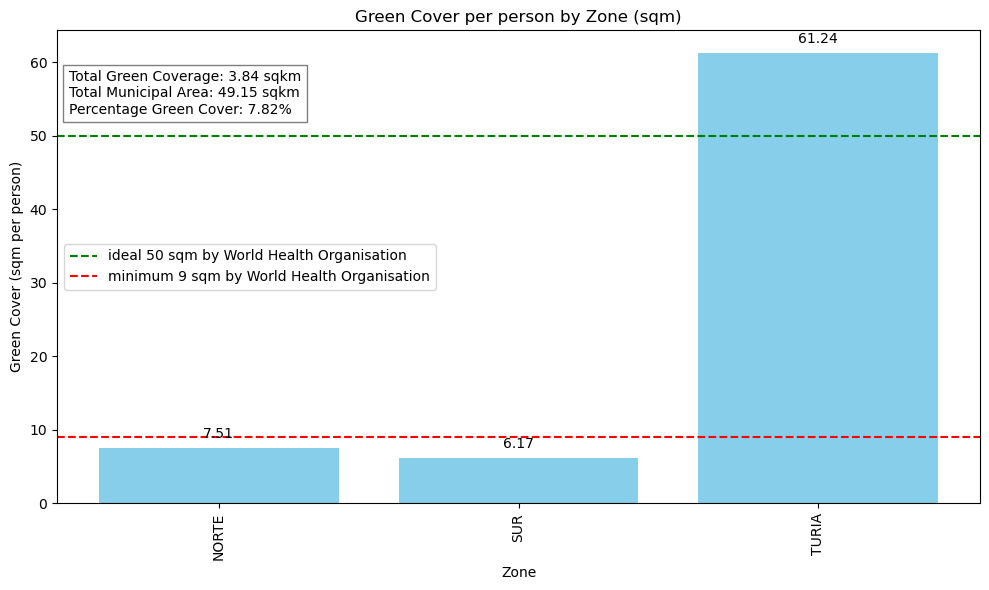

In [43]:
# Barplot Green Cover by Zone (sqm per person)
plt.figure(figsize=(10,6))
bars = plt.bar(data_by_zone['zona'], data_by_zone['sqm_per_person'], color='skyblue')

plt.axhline(y=50, color='green', linestyle='--', label='ideal 50 sqm by World Health Organisation')
plt.axhline(y=9, color='red', linestyle='--', label='minimum 9 sqm by World Health Organisation')

# Add text for area by category
for i, (zona, sqm) in enumerate(zip(data_by_zone['zona'], data_by_zone['sqm_per_person'])):
    plt.text(i, sqm + 1, f'{sqm:,.2f}', ha='center', va='bottom', fontsize=10)

# Add textbox with total green coverage and municipal 
plt.text(-0.5, 53,
         f'Total Green Coverage: {total_green_area_sqkm:,.2f} sqkm\n'
         f'Total Municipal Area: {mun_area_sqkm:,.2f} sqkm\n'
         f'Percentage Green Cover: {green_cover_pct:,.2f}%',
         fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Zone')
plt.ylabel('Green Cover (sqm per person)')
plt.title("Green Cover per person by Zone (sqm)")

plt.xticks(rotation=90)

plt.legend()

plt.tight_layout()
plt.show()

**Zone Norte**: Residents have access to **7.51%** of green space per person, which is below the minimum recommended level.

**Zone Sur**: This zone shows an even lower access rate, with **6.17%** of green space per person, also falling short of the minimum recommendation.

**Zone of the River Park Turia**: In stark contrast, this zone offers an impressive **61.24%** of green space per person, significantly exceeding the ideal recommendation.

These findings reveal significant disparities in green space accessibility among different zones. The notably low percentages in Zones Norte and Sur highlight an urgent need to enhance green infrastructure in these areas to meet global standards. Addressing these gaps is essential for improving residents' quality of life and fostering a healthier urban environment.

4. **Green Area and Population by District**
In addition to zones, the green area and population are also aggregated by administrative districts. The analysis mirrors the zone-level calculations to derive the green space per person in each district. This provides another layer of insight into the distribution of green space at a larger administrative scale.

A second bar plot is created to show the green cover per person across districts, again comparing the results against WHO standards.

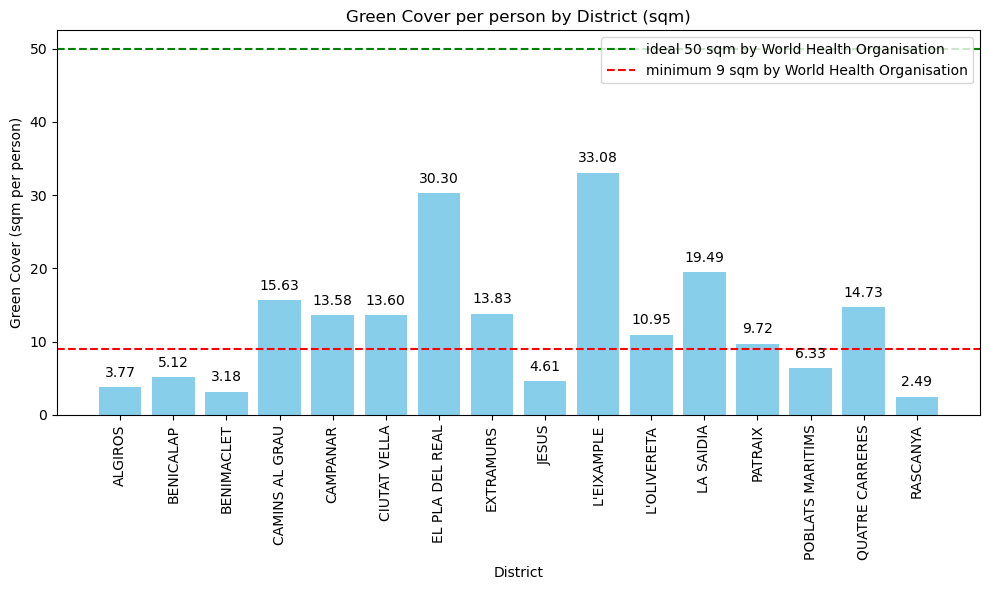

In [46]:
# Barplot Green covergae by District
plt.figure(figsize=(10,6))
bars = plt.bar(data_by_district['dm'], data_by_district['sqm_per_person'], color='skyblue')

plt.axhline(y=50, color='green', linestyle='--', label='ideal 50 sqm by World Health Organisation')
plt.axhline(y=9, color='red', linestyle='--', label='minimum 9 sqm by World Health Organisation')

# Add text for area by category
for i, (zona, sqm) in enumerate(zip(data_by_district['dm'], data_by_district['sqm_per_person'])):
    plt.text(i, sqm + 1, f'{sqm:,.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('District')
plt.ylabel('Green Cover (sqm per person)')
plt.title("Green Cover per person by District (sqm)")

plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

A bar plot illustrating green cover per person across various districts reveals significant differences in accessibility

These findings highlight the disparities in green space access across districts, emphasizing the need for targeted improvements in areas with low green coverage, particularly in Rascanya and Benimaclet, to meet WHO standards and enhance the quality of life for residents.

# Accessibility Index Calculation Using the 2SFCA Method

The Two-Step Floating Catchment Area (2SFCA) method is a widely used technique to measure accessibility to services or amenities, such as green zones, based on population distribution and proximity to those amenities. This section outlines the calculation of the accessibility index using the 2SFCA method, specifically tailored to the context of evaluating access to green zones in a given area.

## Overview of the 2SFCA Method

The 2SFCA method consists of several steps, which include calculating distances, determining weights based on distance decay, and evaluating the supply-to-demand ratios for each green zone. The accessibility index $ A_j $ for each census tract is calculated based on these components.

### Data Preparation

1. **Reproject Coordinate Reference Systems (CRS)**:
   - The datasets are transformed to a common coordinate reference system (EPSG = 25830), which is crucial for accurate distance calculations.

2. **Calculate Centroids**:
   - For each census tract, the centroid (geometric center) is computed to facilitate distance calculations to green zones.

### Distance Calculations

The next step involves calculating the distances between each census tract centroid and the nearest point in each green zone. This is done using the **Manhattan distance**, defined as:

$$d_{ij} = |x_i - x_j| + |y_i - y_j|$$

Where:
- $ d_{ij} $ is the Manhattan distance between census tract $ i $ and green zone $ j $.
- $ (x_i, y_i) $ are the coordinates of the census tract centroid.
- $ (x_j, y_j) $ are the coordinates of the green zone point.

### Weight Calculations

A distance-decay function is used to assign weights based on proximity. The Gaussian distance-decay function $ G(d_{ij}) $ is defined as:

$$
G(d_{ij}, d_0) = \begin{cases}
\frac{\exp\left(-\frac{1}{2}\left(\frac{d_{ij}}{d_0}\right)^2\right) - \exp\left(-\frac{1}{2}\right)}{1 - \exp\left(-\frac{1}{2}\right)} & \text{if } d_{ij} \leq d_0 \\
0 & \text{if } d_{ij} > d_0
\end{cases}
$$

Where:
- $ d_0 $ is a threshold distance (e.g., 500 meters) beyond which the weight is zero.

### Step 1: Supply-to-Demand Ratio Calculation

The supply-to-demand ratio $ R_i $ for each green zone is computed using the formula:

$$
R_i = \frac{S_i}{\sum_{j \in J_i} P_j \cdot w_{ij}}
$$

Where:
- $ S_i $ is the area of the green zone $ i $.
- $ P_j $ is the population of census tract $ j $.
- $ w_{ij} $ is the weight assigned to census tract $ j $ based on its distance to green zone $ i $.
- $ J_i $ is the set of all census tracts that influence green zone $ i $.

### Step 2: Accessibility Index Calculation

The final step is to calculate the accessibility index $ A_j $ for each census tract using the formula:

$$
A_j = \sum_{i \in I_j} R_i \cdot w_{ij}
$$

Where:
- $ R_i $ is the supply-to-demand ratio for green zone $ i $.
- $ w_{ij} $ is the weight for census tract $ j $ based on the distance to green zone $ i $.
- $ I_j $ is the set of all green zones that influence census tract $ j $.

### Normalization

The calculated accessibility index values are normalized to a range between 0 and 1 using Min-Max scaling:

$$
\text{Normalized } A_j = \frac{A_j - A_{\text{min}}}{A_{\text{max}} - A_{\text{min}}}
$$

Where:
- $ A_{\text{min}} $ and $ A_{\text{max}} $ are the minimum and maximum accessibility values across all census tracts.

Finally, the accessibility index is visualized on a map, highlighting the variation in accessibility to green zones across different census tracts.

The 2SFCA method effectively quantifies accessibility by integrating distance calculations, population distributions, and service availability. This method provides valuable insights for urban planners and policymakers seeking to improve access to green spaces and other amenities.

Calculating distances...
Distances saved to precomputed_distances.pkl


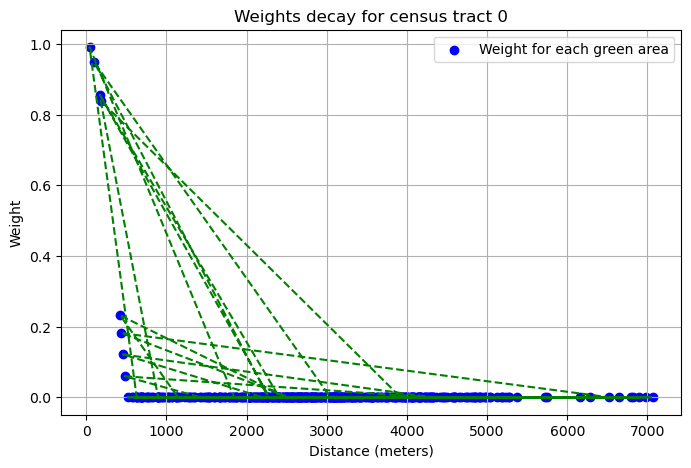

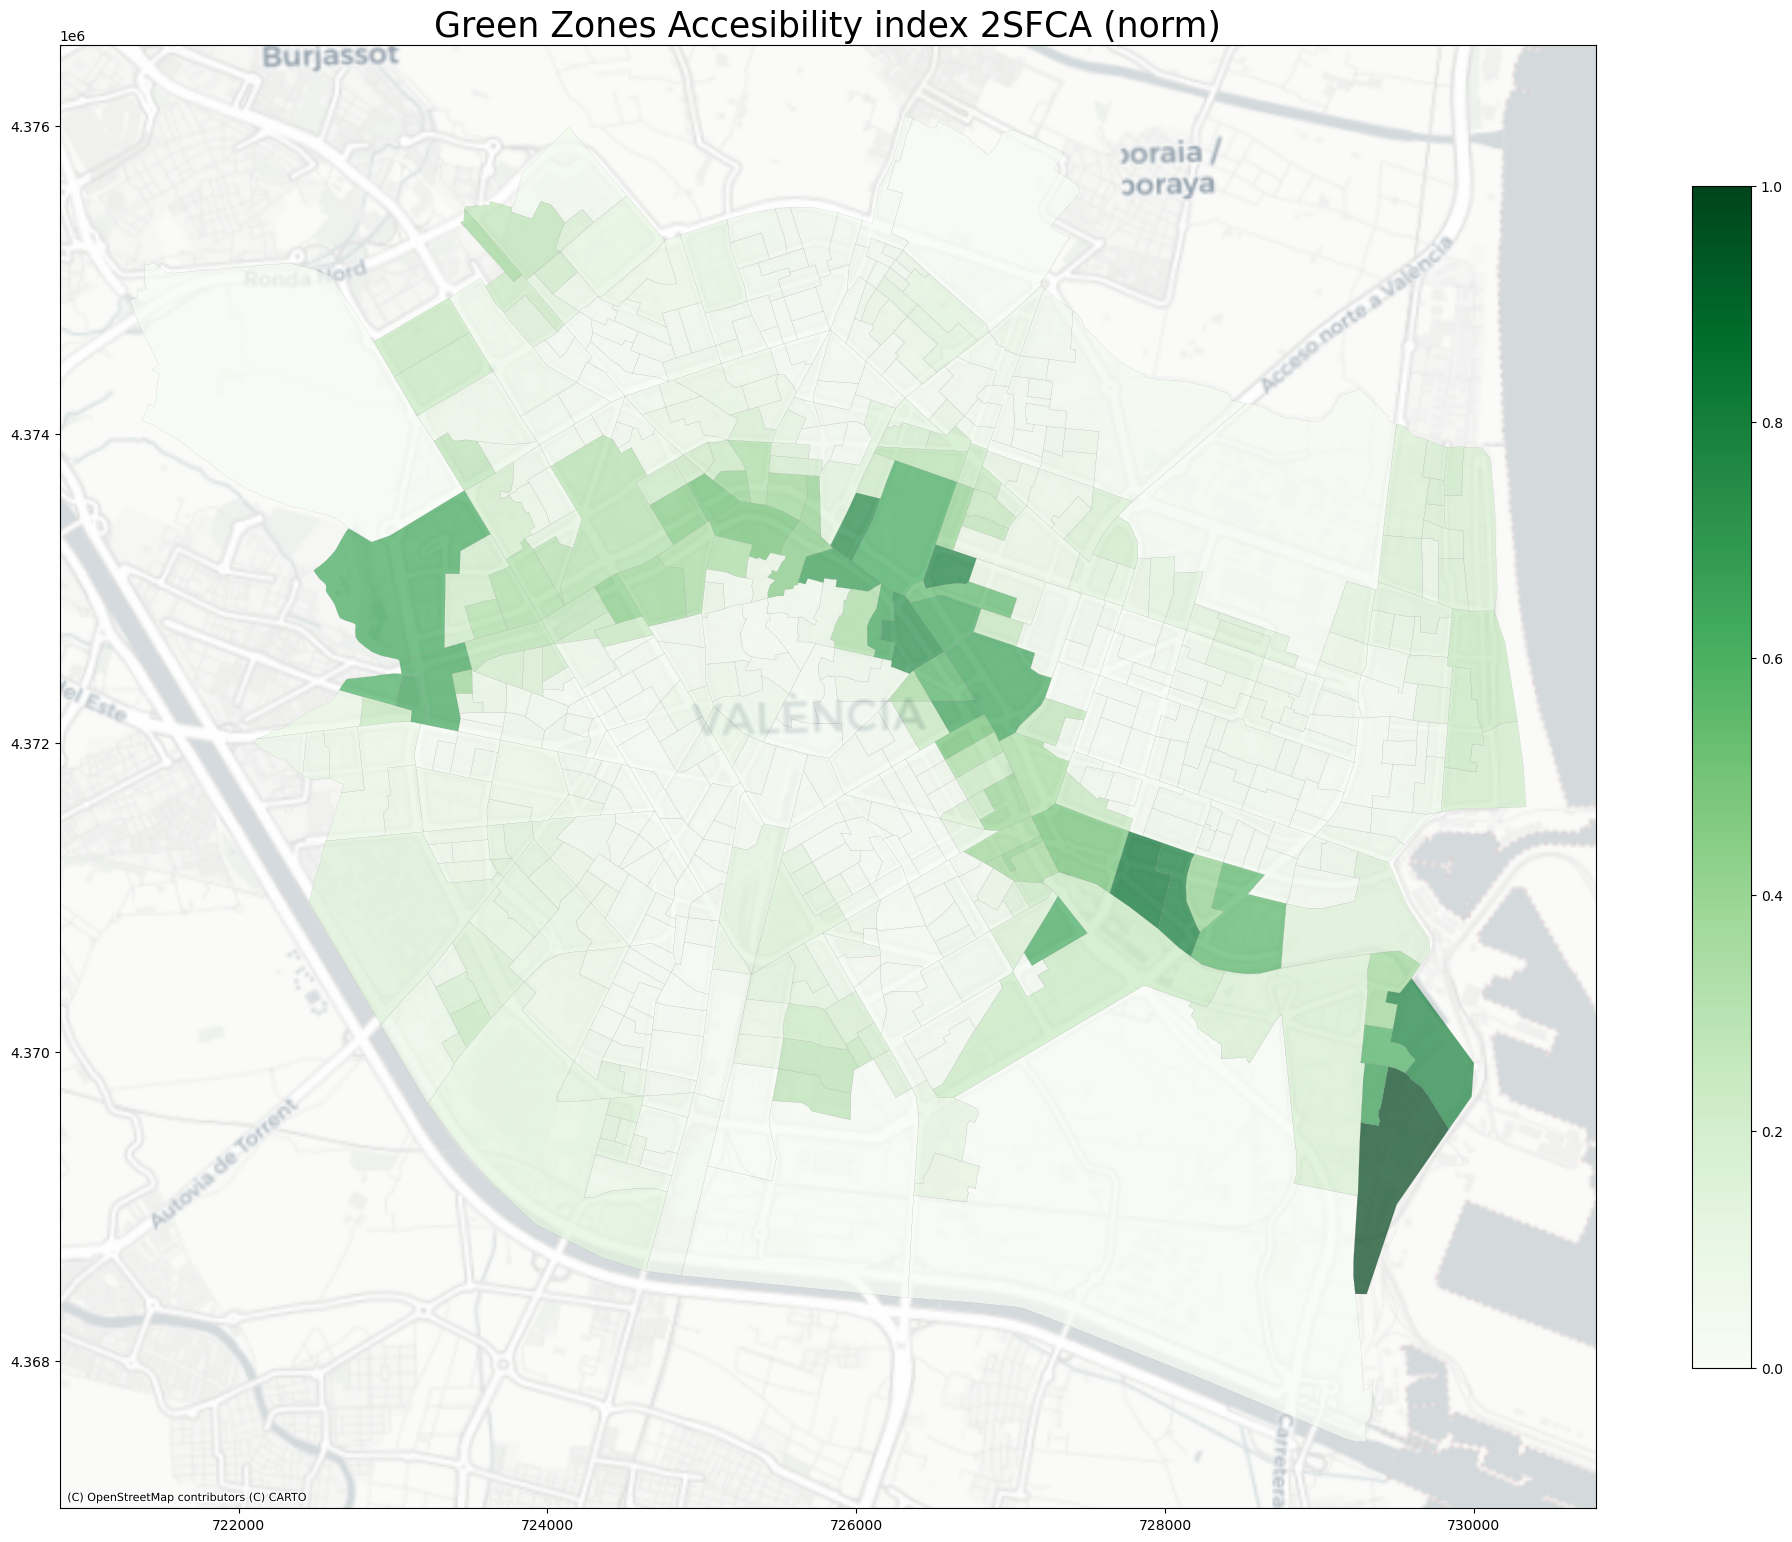

In [76]:
%run f2sfca.py

This map displays the normalized accessibility index of green zones calculated using the Two-Step Floating Catchment Area (2SFCA) method. 

- The color gradient ranges from light green, indicating **low accessibility**, to dark green, representing **high accessibility**.
- A clear **notable pattern** emerges, showing that census tracts with higher accessibility are predominantly located along the river park.

While this initial observation provides valuable insights, a more detailed spatial analysis focusing on both global and local correlations will be conducted in the upcoming sections. This will help deepen our understanding of accessibility dynamics in relation to green zones.

# Spatial Data Analysis

This section employs various spatial data techniques to explore the accessibility of green areas. The analysis utilizes spatial statistical methods to quantify and visualize spatial autocorrelation between census tracts in terms of accessibility to green zones.

In [27]:
%run spatial_analysis.py

## 1. **Global Spatial Correlation Analysis**
The spatial correlation explains the similarity of values of a variable in diferent points in space. Positive spatial correlation refers to that similar values are located near each other, this values can be high or low. Negative spatial autocorrelation, otherwise, means that similar values are disperse in space, located away from each other.

The primary tool for representing and analyzing spatial data is the choropleth map. To create such a map, it's essential to define the number of intervals for mapping the studied variable and select a classification algorithm for accurate representation. In this analysis we use the Fisher-Jenks classification method with k=7 to categorize accessibility levels, effectively balancing the complexity of the map and the representation of significant data variations.

**Construction of Spatial Weights**

To understand the spatial structure and patterns of the city, it is essential to define the connectivity between units. There are different types of spatial relationships; in this analysis, we use a kernel function, which defines relationships between census tracts based on proximity. The kernel weights are adaptive, adjusting to local density by varying neighbor distances. This method ensures that each census tract has a fixed number of neighbors, providing a more refined understanding of spatial connections. 

Upon observing that the sections have a range of 1 to 16 neighbors, with a mode of 7 neighbors, a maximum k of 16 neighbors was selected to adequately capture this diversity.

The underlying principle is that closer points have a stronger connection than those farther away. The triangular function used assigns weights that decrease linearly with distance from the focal point.

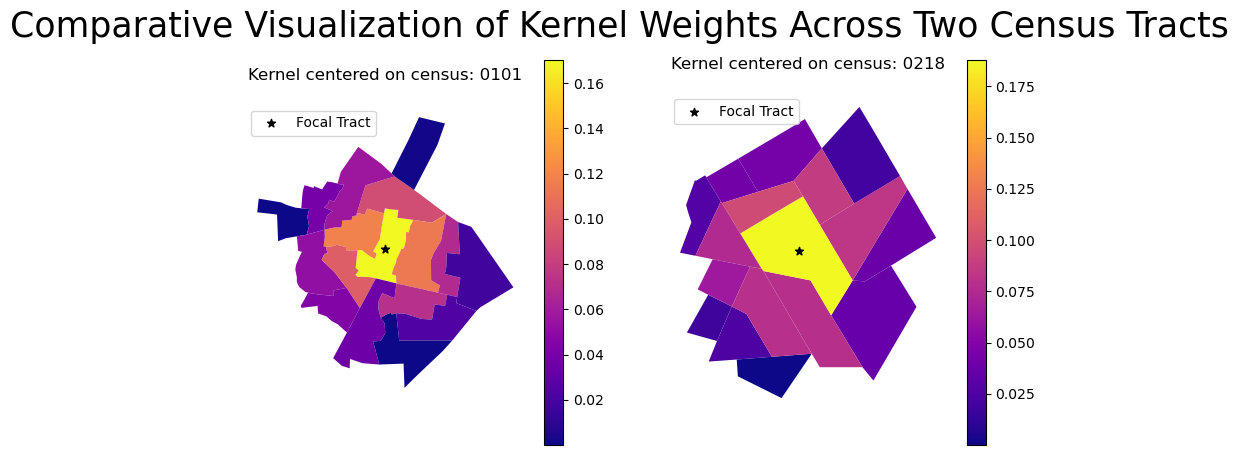

In [30]:
# Plot kernel weights
f, ax = plt.subplots(
    1,2, figsize = (10,5), subplot_kw=dict(aspect="equal")
    )
census.assign(w_0=w[0]).plot(
    "w_0", cmap='plasma', ax=ax[0], legend=True) # Append weights on 0 census and plot

census.assign(w_100 = w[100]).plot(
    "w_100", cmap='plasma', ax=ax[1], legend=True)

census.iloc[[0], :].centroid.plot(
    ax=ax[0], marker = "*", color='k', label="Focal Tract")

census.iloc[[100], :].centroid.plot(
    ax=ax[1], marker = "*", color = 'k', label = "Focal Tract")

ax[0].set_title(f"Kernel centered on census: {census.iloc[0]['coddistsecc']}")
ax[1].set_title(f"Kernel centered on census: {census.iloc[35]['coddistsecc']}")

[ax_.set_axis_off() for ax_ in ax]
[ax_.legend(loc='upper left') for ax_ in ax]

plt.suptitle("Comparative Visualization of Kernel Weights Across Two Census Tracts", fontsize = 25)
plt.show()

**Spatial Lag Model**

The direct application of the weights matrix is a spatial lag model. Spatial Lag helps to understand how the values of a variable, such as 2SFCA (Two-Step Floating Catchment Area),
in one section are influenced by the values in neighboring sections. It effectively captures the spatial dependence, revealing how accessibility to green areas in one location is shaped by the surrounding areas, acting as a local "smoother" of the variable across the spatial context. $Y_{sl}=W*Y$

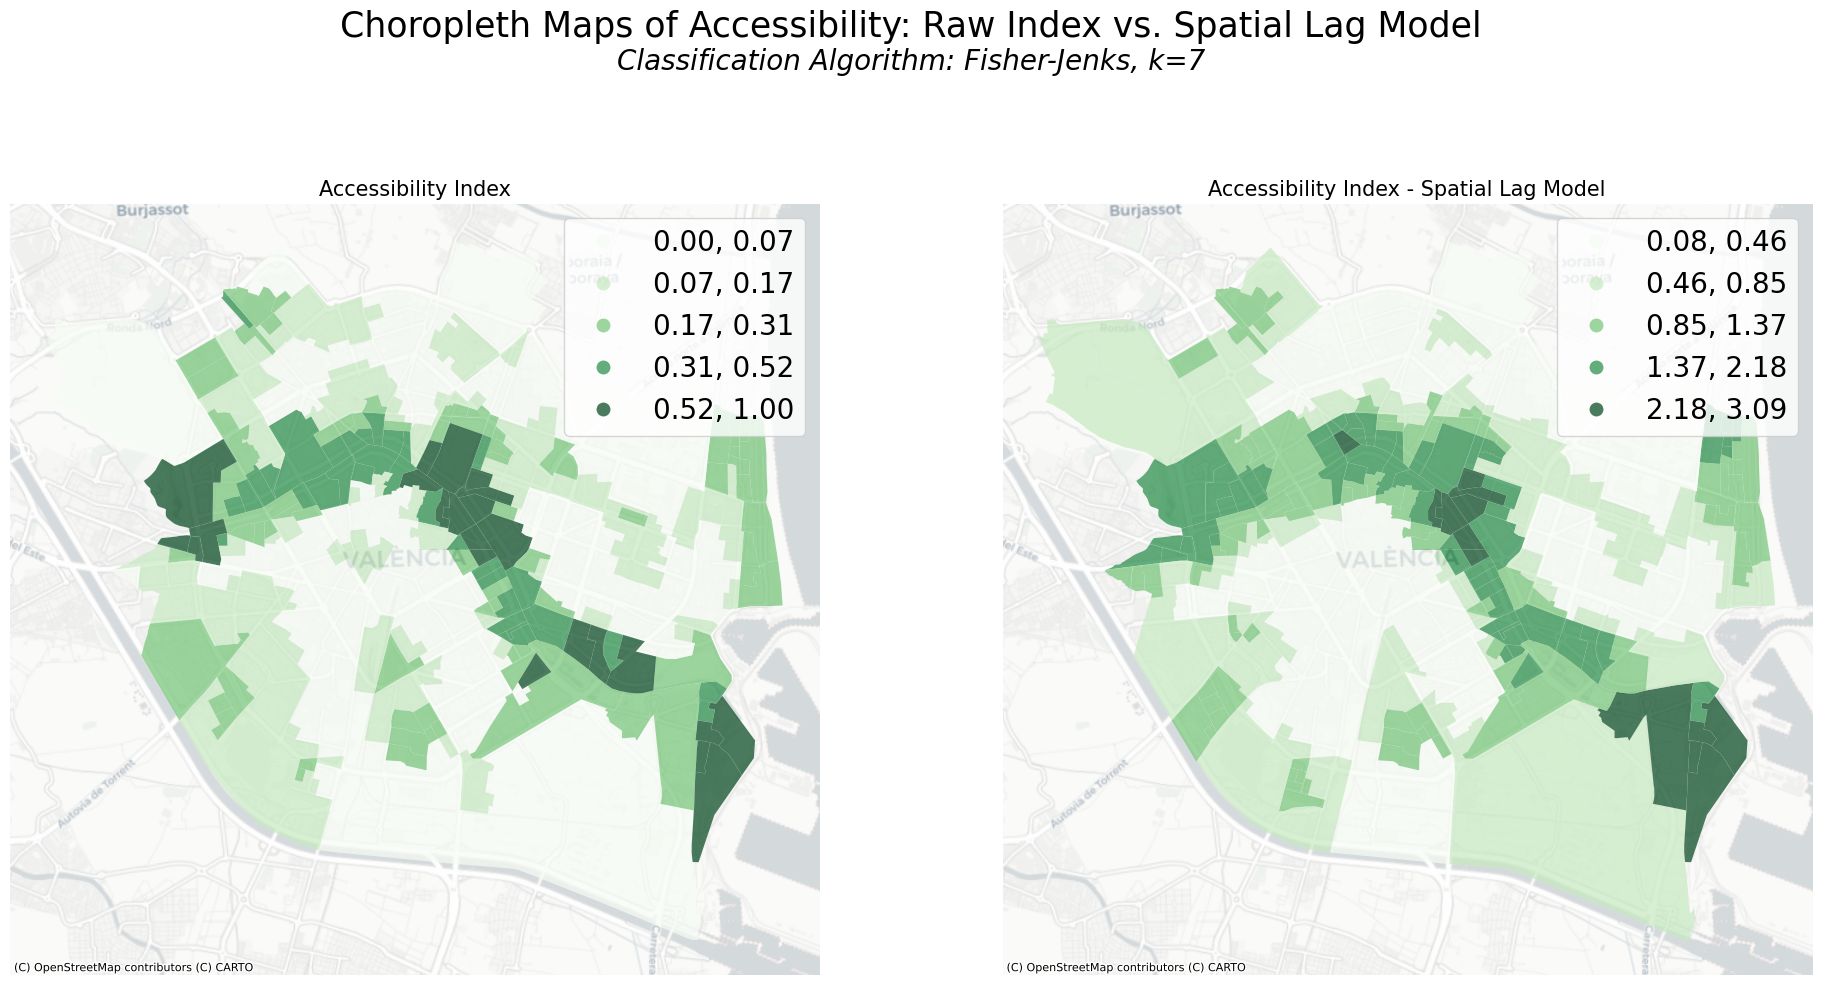

In [35]:
# Choroplet map: Accesibility vs Accesibilty_Spatial Lag
f, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot accesibility
census.plot(
    column='acces_norm',
    cmap='Greens',
    scheme='FisherJenks',
    k=5,
    edgecolor='white',
    linewidth=0.05,
    alpha=0.7,
    legend=True,
    ax=ax[0],
    legend_kwds={'fontsize': 20}
)

ctx.add_basemap(ax[0], crs=census.crs, source=ctx.providers.CartoDB.Positron)
ax[0].set_axis_off()
ax[0].set_title("Accessibility Index", size=15)

# Plot spatial lag model
census.plot(
    column='acces_lag',
    cmap='Greens',
    scheme='FisherJenks',
    k=5,
    edgecolor='white',
    linewidth=0.05,
    alpha=0.7,
    legend=True,
    ax=ax[1],
    legend_kwds={'fontsize': 20}
)

ctx.add_basemap(ax[1], crs=census.crs, source=ctx.providers.CartoDB.Positron)
ax[1].set_axis_off()
ax[1].set_title("Accessibility Index - Spatial Lag Model", size=15)

# Set the main title
plt.suptitle("Choropleth Maps of Accessibility: Raw Index vs. Spatial Lag Model", fontsize=25)

# Set the subtitle in italics using figtext
plt.figtext(0.5, 0.92, "Classification Algorithm: Fisher-Jenks, k=7", ha='center', fontsize=20, fontstyle='italic')

# Adjust layout to prevent overlap
plt.subplots_adjust(top=0.85)  # Adjust top value

plt.tight_layout(rect=[0, 0, 1, 0.85])  # Adjust rect to give room for the title and subtitle
plt.show()

**Moran's I**

To interpret the geographic patterns observed in the maps and avoid potential errors, the Moran statistic is employed to assess the significance of the patterns.

Moran's I indicates whether nearby locations exhibit similar values for a given variable such as green zone accesibility index.

The Moran Plot visually represents this relationship by plotting the standardized values of a variable against its spatial lag, helping to identify clusters or patterns of similarity in green zone accessibility across different regions. 

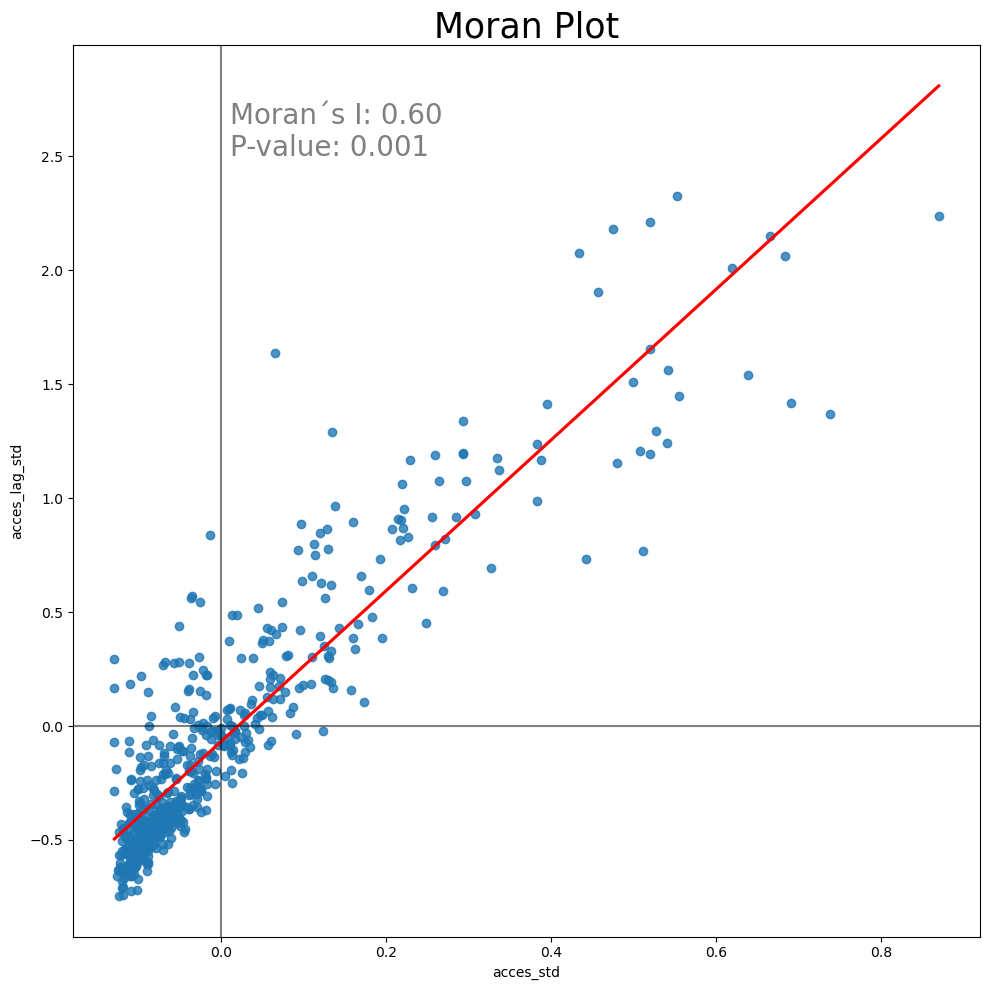

In [37]:
# Moran Plot
fig, ax = plt.subplots(figsize = (10,10))
sns.regplot(
    x = 'acces_std',
    y = 'acces_lag_std',
    ci = None,
    data = census,
    line_kws={"color": "r"},
    ax=ax)
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c = "k", alpha = 0.5)

plt.text(0.01, 2.5,
         f"Moran´s I: {mi_acces.I:,.2f}\n"
         f"P-value: {mi_acces.p_sim.mean()}", size = 20, c='grey')

plt.title("Moran Plot", size = 25)

plt.tight_layout()
plt.show()

A Moran's I value of 0.60 indicates a moderate to strong positive spatial autocorrelation. This suggests that areas with high accessibility to green zones are likely clustered together, as are areas with low accessibility. 
The p-value of 0.001 indicates that the observed spatial autocorrelation is statistically significant. This means that the likelihood of obtaining a Moran's I value of 0.60 or higher due to random chance is very low. 

Therefore, the pattern observed is not due to random variation but reflects a real spatial phenomenon.

## 2. **Local Spatial Correlation Analysis**
The global Moran's index indicates the overall tendency of clustering on a map but does not specify the locations of high or low value clusters. To identify these clusters, the local Moran's index is employed, which reflects autocorrelation across different areas of the study region. While the global index produces a single summary value, the local index generates multiple values for various areas. For a comprehensive view, each section is assigned to a quadrant (High-High, Low-Low, High-Low, Low-High) and statistical significance is evaluated (p_sim < 0.05). This data is then visualized on a map with color-coded categories.

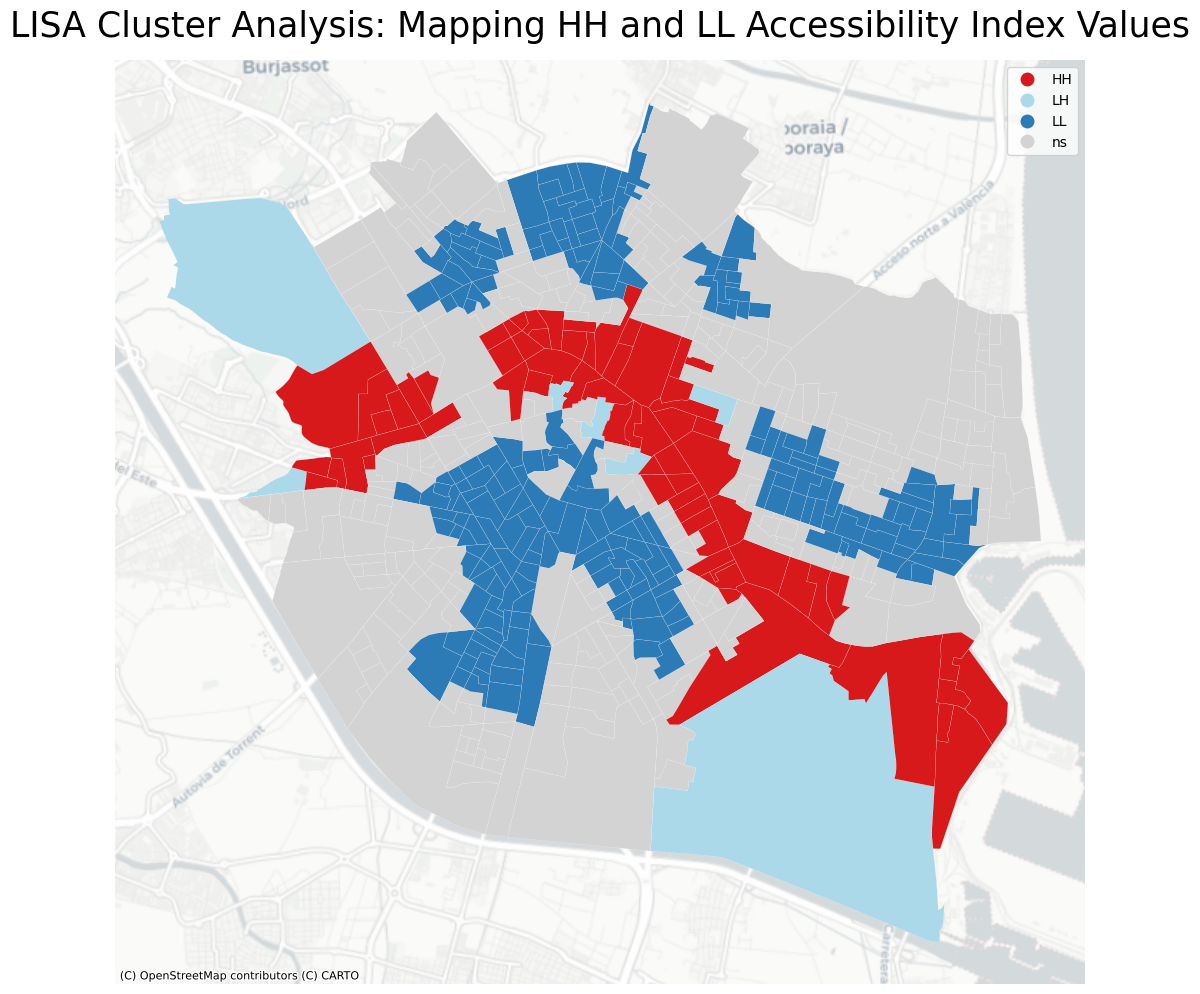

In [52]:
# LISA CLuster map
fig, ax = plt.subplots(figsize = (10,10))
esdaplot.lisa_cluster(lisa, census, p = 0.05, ax=ax)
ctx.add_basemap(ax, crs=census.crs, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("LISA Cluster Analysis: Mapping HH and LL Accessibility Index Values", size =25)

plt.tight_layout()
plt.show()

As previously observed, spatial clusters with high accessibility values are concentrated in the central area near the river park, while statistically significant low values are clustered in the northern and southern parts of the city.

# Geographically Weighted Regression

Ordinary Least Squares (OLS) regression models linear relationships between dependent and independent variables; however, it assumes no autocorrelation, which is often violated in spatial data where neighboring values tend to be similar. To address this issue, Geographically Weighted Regression (GWR) is employed, allowing regression coefficients to vary spatially by estimating different coefficients for each location.

In [74]:
%run gwr.py

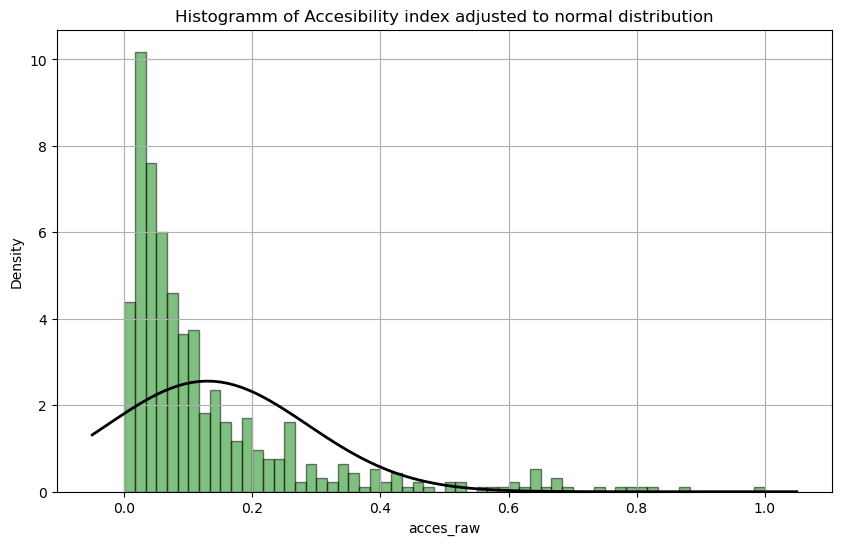

In [76]:
# Plot Histogram Distribution 'Accesibility'
plt.figure(figsize=(10,6))
plt.hist(y, bins=60, density=True, alpha=0.5, color='g', edgecolor='black')

# Adjust a curve for normal distribution
mu, std = norm.fit(y)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Histogramm of Accesibility index adjusted to normal distribution"
plt.title(title)
plt.xlabel('acces_raw')
plt.ylabel('Density')

plt.grid(True)
plt.show()

The positive skewness in the accessibility index distribution highlights spatial inequality in access to green spaces. We already detected these unequalities in local analysis. The long right tail of the distribution indicates the presence of outliers—areas with high accessibility due to proximity to large or multiple green spaces. 

The positive skew also implies that the dependent variable (green zone accessibility) deviates from a normal distribution, which could violate assumptions in statistical models. While Geographically Weighted Regression (GWR) is robust to moderate deviations from normality, extreme skewness might affect the reliability of local coefficient estimates. High-accessibility areas could disproportionately influence the GWR results, leading to stronger local relationships in those zones while producing weaker or insignificant relationships in low-accessibility areas.

To address the skewness and potentially improve model performance, Box-Cox transformation is applied to correct for the skew and stabilize variance.